#   NGC 4321 : examples of using Hershel spectral data


Data can be downloaded via http://archives.esac.esa.int/hsa/whsa (**HSA**)
you will pick an Observation ID (ObsID), a 10 digit number. Apart from a top level convenience directory name, the extracted tar file will typically have a multi-level directory structure, starting with the ObsID. We will be mostly (if not all) use the **level2** products, e.g.

    1342223728/level2/HPS3DB/herschel.pacs.signal.PacsCube/hpacs1342223728_20hps3dbs_08_1469459187154.fits.gz 

For this galaxy there is also KINGFISH data available, but these are differently (better) organized, as they have gone through additional processing steps.

We will only be using PACS and SPIRE, and ignore the single pixel HIFI data (which covers roughly the same spectral range as SPIRE, but with very high spectral resolution)

![image](pacs+spire.png)

# Oberving Modes

These are the HSA observing modes, and which OID's are discussed below

    
    SpirePacsParallel       1342198147 (comes in a separate PACS and SPIRE oid)
    PacsLineSpec            1342223728 (the first of the 9 Kingfish) 1342199746 and 1342199747 via rguesten
    SpireSpectroPoint       1342247572
    PacsPhoto               1342212438
    SpirePhotoLargeScan     
    HiFi.....               n/a here



# Spectral Data

We will only be using  PACS (red and blue) and SPIRE (SSW and SLW) spectra. The examples below also show how to plot the positions of the spectra on some images that are available. For NGC 4321 we have the following ObsID's for the spectra:

    PACS:   1342199746,1342199747,1342223728-1342223735,1342223758   (11 in total)
    SPIRE:  1342247572
    
    

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import glob
from astropy.io import fits
import aplpy

Below are some simple access functions, for more flexible processing a class based system would be ideal.

In [2]:
def get_radec_spire(ffile):
    """
    Return a list of (ra,dec) of the pointing in this bintable from the SPIRE data\
    Such files have 17 or 18 columns:
    wave, flux, error, longitude, latitude
    """
    print("get_radec_spire:",ffile)
    hdu = fits.open(ffile)
    print(len(hdu),'luns')
    hdr = hdu[1].header
    dat = hdu[1].data
    if hdr['EXTNAME'] != 'spectrum2d':
        print("Bad EXTNAME = ",hdr['EXTNAME'])
        return None
    ra = dat['longitude']
    dec = dat['latitude']
    waves = hdu[1].data['wave']
    print("wave:",waves.min(),waves.max())
    #fluxs = hdu[1].data['flux']
    return (ra,dec)

def get_radec_pacs(ffile):
    """
    Return a list of (ra,dec) of the pointing in this bintable from the PACS data\
    Such files have 11 columns:
    wave, flux, error, longitude, latitude
    """
    print("get_radec_pacs:",ffile)
    hdu = fits.open(ffile)
    print(len(hdu),'luns')
    hdr = hdu[1].header
    dat = hdu[1].data
    if hdr['EXTNAME'] != 'Spectra':
        print("Bad EXTNAME = ",hdr['EXTNAME'])
        return None
    ra = dat['RightAscension']
    dec = dat['Declination']
    print("Spectra",len(ra))
    waves = hdu[1].data['Wavelength']
    print("Wavelength:",waves.min(),waves.max())
    #fluxs = hdu[1].data['Flux']
    return (ra,dec)

def get_image(ffile):
    """
    return the HDU, Header,Data of an image
    """
    print('get_image:',ffile)
    hdu = fits.open(ffile)
    print(len(hdu),'luns')
    imh = hdu[1].header
    imd = hdu[1].data
    if imh['EXTNAME'] != 'image':
        print("Bad EXTNAME = ",hdr['EXTNAME'])
        return None
    print(imd.shape)
    if len(imd.shape)>2:
        if 'CRVAL3' in imh:
            ch0 = (            1-imh['CRPIX3'])*imh['CDELT3']+imh['CRVAL3']
            chN = (imh['NAXIS3']-imh['CRPIX3'])*imh['CDELT3']+imh['CRVAL3']
            print('Spectral axis:',ch0,chN,imh['CUNIT3'])
        else:
            print("Spectral axis:",imh['CTYPE3'])
    return (hdu[1],imh,imd)

def get_spire(dirname):
    """
    return a dictionary of the fits.gz files from a SPIRE (or PACS) hierarchy one level deep, e.g.
    
    d = get_spire('1342247572/level2')
    gives
    d['HR_SSW_CUBE'] = '1342247572/level2/HR_SSW_cube/hspirespectrometer1342247572_spg_SSW_HR_20ssc_1461672208855.fits.gz'
    """
    fns = glob.glob(dirname + '/*/*.fits.gz')
    d = {}
    for fn in fns:
        fn2 = fn.split('/')
        if fn2[-2] in d:
            print("Multiple entries for",fn2[-2])
        d[fn2[-2]] = fn
    return d

def get_pacs(dirname):
    """
    return a dictionary of the set of fits.gz files from a PACS hierarchy two levels deep, e.g.
    
    unlike get_spire(), this one allows multiple fits files per entry
    """
    fns = glob.glob(dirname + '/*/*/*.fits.gz')
    d = {}
    for fn in fns:
        fn2 = fn.split('/')
        if fn2[-3] in d:
            d[fn2[-3]].append(fn)
        else:
            d[fn2[-3]] = [fn]
    return d

# SPIRE oid = 1342247572

# SpireSpectroPoint

There is only one **SpireSpectroPoint** for NGC 4321. On level2 we find the following datasets:

    HR_SLW_cube                       8 x 7 x 1906
    HR_SLW_cube_apod
    HR_SLW_cube_convol
    HR_SLW_cube_convol_apod
    HR_SLW_spectrum2d                 17 x 76   (76 pointings of 1906 chans)
    HR_SLW_spectrum2d_apod
    HR_SSW_cube                       12 x 13 x 2082
    HR_SSW_cube_apod
    HR_SSW_cube_convol
    HR_SSW_cube_convol_apod
    HR_SSW_spectrum2d                 18 x 140  (140 pointings of 2082 chans)
    HR_SSW_spectrum2d_apod
    
    


In [3]:
spire = get_spire('1342247572/level2')

slw_spectrum2d = spire['HR_SLW_spectrum2d']
(ra1,dec1) = get_radec_spire(slw_spectrum2d)
print('SLW has %d pointings, probably %g jiggles' % (len(ra1),len(ra1)/19))     # 19, but aren't two dead?

ssw_spectrum2d = spire['HR_SSW_spectrum2d']
(ra2,dec2) = get_radec_spire(ssw_spectrum2d)
print('SSW has %d pointings, probably %g jiggles' % (len(ra2),len(ra2)/35))     # i thought there were 37 detectors

get_radec_spire: 1342247572/level2/HR_SLW_spectrum2d/hspirespectrometer1342247572_spg_SLW_HR_20spc_1461672208029.fits.gz
2 luns
wave: 446.99055488 1017.79539491
SLW has 76 pointings, probably 4 jiggles
get_radec_spire: 1342247572/level2/HR_SSW_spectrum2d/hspirespectrometer1342247572_spg_SSW_HR_20spc_1461672211449.fits.gz
2 luns
wave: 944.04645024 1567.91455534
SSW has 140 pointings, probably 4 jiggles


In [4]:
ssw_cube = spire['HR_SSW_cube']
slw_cube = spire['HR_SLW_cube']

In [5]:
(hdu1,h1,d1) = get_image(slw_cube)

get_image: 1342247572/level2/HR_SLW_cube/hspirespectrometer1342247572_spg_SLW_HR_20ssc_1461672206639.fits.gz
5 luns
(1905, 7, 8)
Spectral axis: 446.99055488 1017.79539491 GHz


INFO: Auto-setting vmin to -3.323e-19 [aplpy.core]
INFO: Auto-setting vmax to  9.405e-19 [aplpy.core]


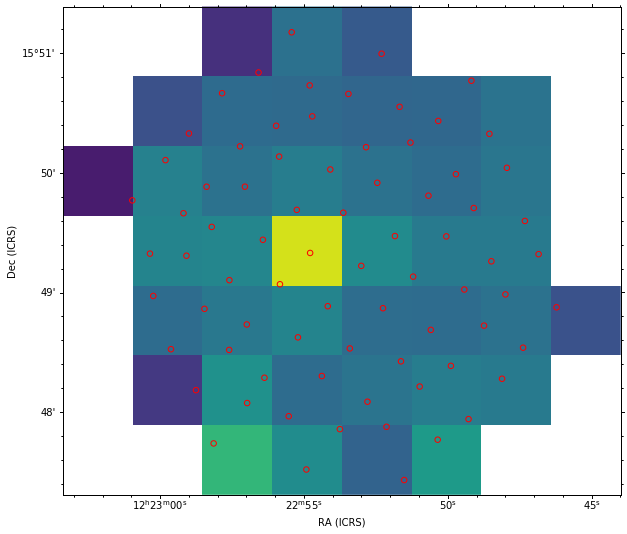

In [6]:
gc = aplpy.FITSFigure(hdu1,slices=[805])
gc.show_colorscale()
gc.show_markers(ra1,dec1)

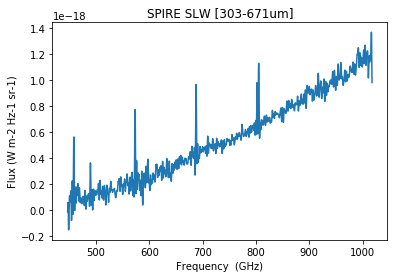

In [7]:
xpos = 3
ypos = 3
sp1 = d1[:,ypos,xpos]
ch1 = np.arange(len(sp1))
ch1 = (ch1+1-h1['CRPIX3'])*h1['CDELT3']+h1['CRVAL3']
plt.plot(ch1,sp1)
plt.xlabel("%s  (%s)" %  (h1['CTYPE3'],h1['CUNIT3']))
plt.ylabel("Flux (%s)" % h1['BUNIT'])
# or zoom in around a line, the numbers here are channel numbers still
#plt.xlim(0,200)
#plt.xlim(700,900)
#plt.xlim(350,500)
#plt.xlim(1100,1300)
#plt.xlim(1750,1900)
#plt.xlim(750,820)
plt.title("SPIRE SLW [303-671um]");

In [8]:
(hdu2,h2,d2) = get_image(ssw_cube)

get_image: 1342247572/level2/HR_SSW_cube/hspirespectrometer1342247572_spg_SSW_HR_20ssc_1461672208855.fits.gz
5 luns
(2082, 13, 12)
Spectral axis: 944.04645024 1567.91455534 GHz


INFO: Auto-setting vmin to -4.480e-19 [aplpy.core]
INFO: Auto-setting vmax to  4.310e-18 [aplpy.core]


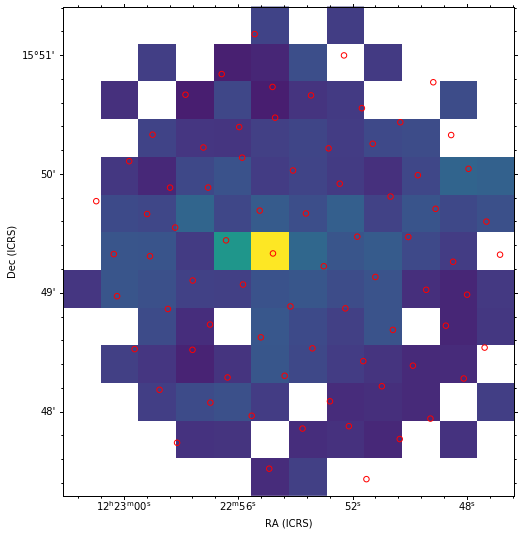

In [9]:
gc = aplpy.FITSFigure(hdu2,slices=[805])
gc.show_colorscale()
gc.show_markers(ra1,dec1)

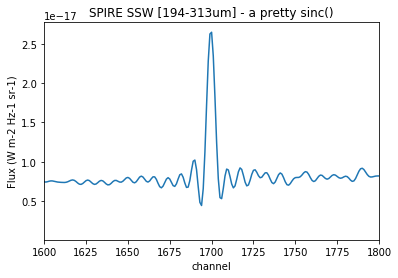

In [10]:
xpos = 5
ypos = 6
sp2 = d2[:,ypos,xpos]
ch2 = np.arange(len(sp2))
#ch2 = (ch2+1-h2['CRPIX3'])*h2['CDELT3'] + h2['CRVAL3']
plt.plot(ch2,sp2)
#plt.xlabel("%s  (%s)" %  (h2['CTYPE3'],h2['CUNIT3']))
plt.xlabel('channel')
plt.ylabel("Flux (%s)" % h2['BUNIT'])
plt.title("SPIRE SSW [194-313um] - a pretty sinc()")
#plt.title(slw_cube)
# or zoom in around a line, and see a pretty sinc
plt.xlim(1600,1800);

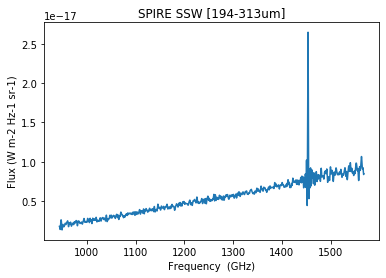

In [11]:
xpos = 5
ypos = 6
sp2 = d2[:,ypos,xpos]
ch2 = np.arange(len(sp2))
ch2 = (ch2+1-h2['CRPIX3'])*h2['CDELT3'] + h2['CRVAL3']
plt.plot(ch2,sp2)
plt.xlabel("%s  (%s)" %  (h2['CTYPE3'],h2['CUNIT3']))
plt.ylabel("Flux (%s)" % h2['BUNIT'])
plt.title("SPIRE SSW [194-313um]");

## what about apod and convol

Especially in this last example, where the sinc function is so clearly visible, how do they look in the _apod_ and _convol_ cubes.

In [12]:
def get_spectrum(ffile,xpos,ypos):
    """
    SPIRE 
    """
    (hdu,h,d) = get_image(ffile)
    sp = d[:,ypos,xpos]
    ch = np.arange(len(sp))
    print("Spectrum min/max",sp.min(),sp.max())
    return (ch,sp)

get_image: 1342247572/level2/HR_SSW_cube/hspirespectrometer1342247572_spg_SSW_HR_20ssc_1461672208855.fits.gz
5 luns
(2082, 13, 12)
Spectral axis: 944.04645024 1567.91455534 GHz
Spectrum min/max 1.329154213886119e-18 2.646008741938101e-17
get_image: 1342247572/level2/HR_SSW_cube_apod/hspirespectrometer1342247572_spgApod_SSW_HR_20ssc_1461672209372.fits.gz
9 luns
(2082, 13, 12)
Spectral axis: 944.04645024 1567.91455534 GHz
Spectrum min/max 1.6186047323085841e-18 1.8822066453699192e-17
get_image: 1342247572/level2/HR_SSW_cube_convol/hspirespectrometer1342247572_spg_SSW_convol_HR_20ssc_1461672209910.fits.gz
5 luns
(2082, 13, 12)
Spectral axis: 944.04645024 1567.91455534 GHz
Spectrum min/max 9.36889977942036e-19 1.7050233608815748e-17
get_image: 1342247572/level2/HR_SSW_cube_convol_apod/hspirespectrometer1342247572_spgApod_SSW_convol_HR_20ssc_1461672210690.fits.gz
9 luns
(2082, 13, 12)
Spectral axis: 944.04645024 1567.91455534 GHz
Spectrum min/max 9.85789905569733e-19 1.2282975143332896e-17


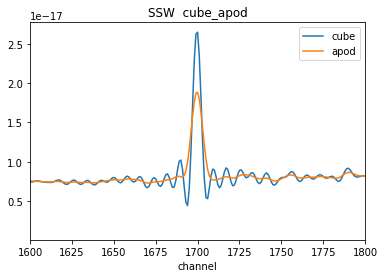

In [13]:
xpos = 5
ypos = 6
(cha1,spe1) = get_spectrum(spire['HR_SSW_cube'],xpos,ypos)
(cha2,spe2) = get_spectrum(spire['HR_SSW_cube_apod'],xpos,ypos)
(cha3,spe3) = get_spectrum(spire['HR_SSW_cube_convol'],xpos,ypos)
(cha4,spe4) = get_spectrum(spire['HR_SSW_cube_convol_apod'],xpos,ypos)
plt.plot(cha1,spe1,label='cube')
plt.plot(cha2,spe2,label='apod')
plt.xlabel('channel')
plt.title("SSW  cube_apod")
plt.legend()
plt.xlim(1600,1800);

##   Both spectra on the same plot?

We can try showing the whole PACS SS and SL range in one plot, but there is a pixel (size) mismatch and possibly a calibration mismatch as well. Possibly the individual spectra from the **spectrum2d**
raw drizzles might give a better match?


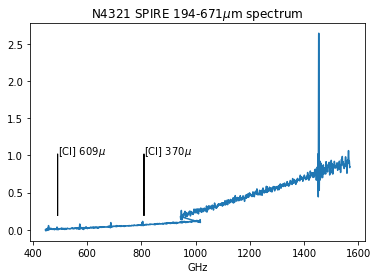

In [36]:
sp3 = np.concatenate((sp1,sp2))
ch3 = np.concatenate((ch1,ch2))
plt.plot(ch3,sp3*1e17)
plt.title("N4321 SPIRE 194-671$\mu$m spectrum")
plt.xlabel("GHz");
#
#   plot a few lines..... oh we need a function for this.
(ymin,ymax) = plt.ylim()
dy = ymax-ymin
plt.text(492,ymin+0.4*dy,'[CI] 609$\mu$')
plt.text(810,ymin+0.4*dy,'[CI] 370$\mu$')
plt.arrow(492,ymin+0.4*dy,0,-0.2*dy,head_width=0.15, head_length=0.25, fc='k', ec='k')
plt.arrow(810,ymin+0.4*dy,0,-0.2*dy,head_width=0.15, head_length=0.25, fc='k', ec='k')

An example how to use a spectrum from the **spectrum2d**. 

# PACS oid = 1342212438

This is a **PacsPhoto** , **B** refers to Blue (55-105u), **R** refers to Red (105-210u)

    HPPPMAPB       6241 x 6521
    HPPPMAPR       6242 x 6522

We will overlay the (ra,dec) positions from the **SpireSpectroPoint** on these images. In this case they are 3x drizzled from the detectors that SPIRE has.


In [15]:
# even though these are PACS photos, we use the get_spire() to access these 1-level deep fits files
hpppmap = get_spire('1342212438/level2')


In [16]:
(hdu1,h1,d1) = get_image(hpppmap['HPPPMAPB'])
print(d1.shape,d1.min(),d1.max(),d1.mean(),d1.std())

get_image: 1342212438/level2/HPPPMAPB/hpacs1342212438_20hpppmapb_00_1469367980473.fits.gz
10 luns
(854, 763)
(854, 763) -0.020666764339736833 0.11612247185016154 6.300825898138048e-05 0.0012960774092399025


INFO: Auto-setting vmin to -3.939e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.511e-03 [aplpy.core]
76 pointings


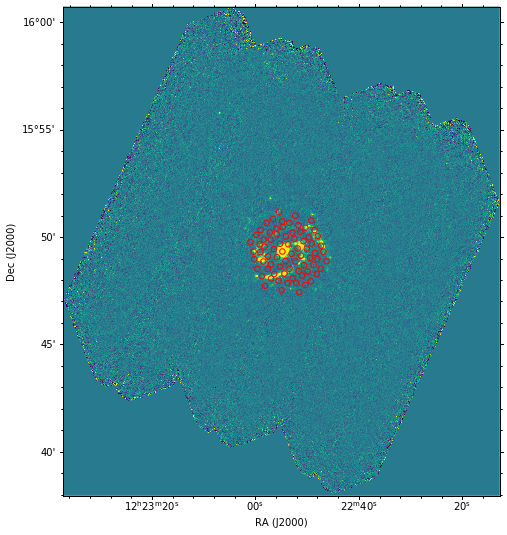

In [17]:
gc = aplpy.FITSFigure(hdu1)
gc.show_colorscale()
gc.show_markers(ra1,dec1)
print(len(ra1), 'pointings')

In [18]:
(hdu2,h2,d2) = get_image(hpppmap['HPPPMAPR'])

get_image: 1342212438/level2/HPPPMAPR/hpacs1342212438_20hpppmapr_00_1469367982271.fits.gz
10 luns
(428, 384)


INFO: Auto-setting vmin to -9.424e-03 [aplpy.core]
INFO: Auto-setting vmax to  3.662e-02 [aplpy.core]
140 pointings


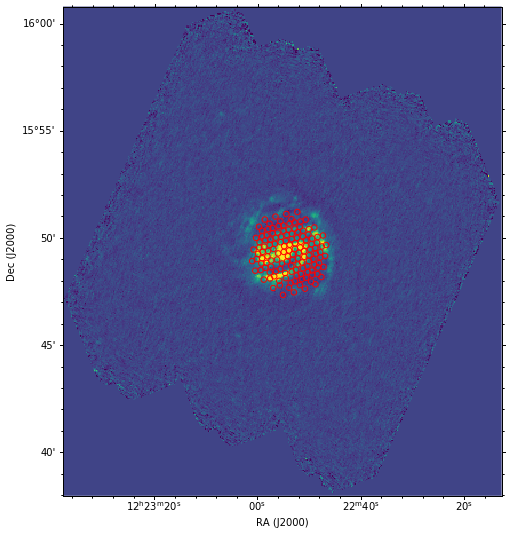

In [19]:
gc = aplpy.FITSFigure(hdu2)
gc.show_colorscale()
gc.show_markers(ra2,dec2)
print(len(ra2),'pointings')

# PACS oid = 1342223728

This is a **PacsLineSpec** , **B** refers to Blue (55-105), **R** refers to Red (105-210)

This is by far the more complex type of datasets.  Here is a summary
   
    
    HPS3DB/herschel.pacs.signal.PacsCube                         00..11   5 x  5 x 24000   flux,wave,ra,dec    
    HPS3DDR/herschel.ia.dataset.spectrum.SpectralSimpleCube      00..01  32 x 32 x 160     image               
    HPS3DEQDR/herschel.ia.dataset.spectrum.SpectralSimpleCube    00..01  34 x 32 x 458     image               
    HPS3DEQIB/herschel.ia.dataset.spectrum.SpectralSimpleCube    00..01  25 x 25 x 769     image              
    HPS3DIB/herschel.ia.dataset.spectrum.SpectralSimpleCube      00..01  25 x 25 x 268     image
    HPS3DPB/herschel.ia.dataset.spectrum.SpectralSimpleCube      00..01  50 x 49 x 268     image
    HPS3DPR/herschel.ia.dataset.spectrum.SpectralSimpleCube      00..01  34 x 32 x 160     image               
    HPS3DRB/herschel.pacs.signal.PacsRebinnedCube                00..08   5 x  5 x 268     image,ra,dec        
    HPS3DR/herschel.pacs.signal.PacsCube                         00..11   5 x  5 x 24000   flux,wave,ra,dec
    HPS3DRR/herschel.pacs.signal.PacsRebinnedCube                00..07   5 x  5 x 160     image,ra,dec
    HPSTBRB/herschel.pacs.signal.PacsSpecTable                   00..01       11 x 26800   Spectra [...]
    HPSTBRR/herschel.pacs.signal.PacsSpecTable                   00..01       11 x 16000 


The naming convention of the Cubes and Tables in PASC spectroscopy can be a bit daunting:

    HPS (Herschel PACS Spectroscopy) + 
       3D (3 dimensions) ) + 
        [EQ] if equidistant + 
           [R|P|I|D] (rebinned,projected, interpolated, or drizzled) + 
                   [BS] if Level 2.5 (background subtracted) + 
                      [R|B] (red or blue). 
       TBR    (Spectra table)
         [R|B]   (red or blue)


In [20]:
pacs = get_pacs('1342223728/level2')
                

# PacsCube

Found 12 in pacsCube
INFO: Auto-setting vmin to -4.415e-03 [aplpy.core]
INFO: Auto-setting vmax to  4.905e-03 [aplpy.core]
0 88.23748400575143 89.44044942632368
1 88.23754384270084 89.44033831776495
2 88.23748393151139 89.44039271668458
3 78.50868047141233 80.12372616898419
4 78.5087451484224 80.1237257871602
5 78.50861723111079 80.12372804463133
6 88.23748331195871 89.44039193901743
7 88.23748720170087 89.44039600508776
8 78.50867977612238 80.12385335777144
9 78.50868037869866 80.12385392730323
10 78.5086832374211 80.12372902031399
11 88.23748368991242 89.44039240844451


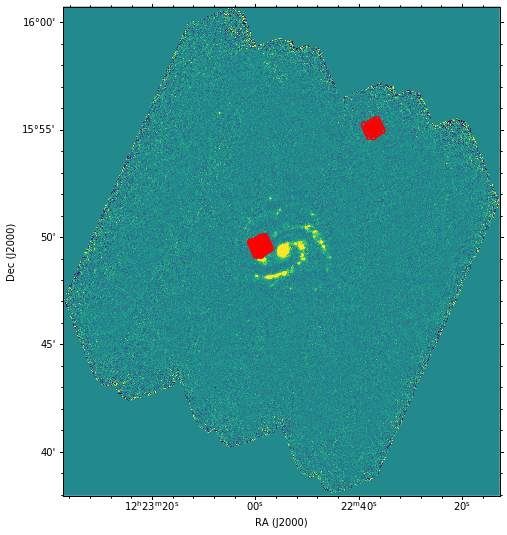

In [21]:
pacsCube = pacs['HPS3DB']   
print('Found %s in pacsCube' % len(pacsCube))

gc = aplpy.FITSFigure(hdu1)
gc.show_colorscale()

for i in range(len(pacsCube)):
    hdu = fits.open(pacsCube[i])
    flux = hdu[1].data
    wave = hdu[2].data
    ra = hdu[3].data
    dec = hdu[4].data
    print(i,wave.min(),wave.max())
    #print(flux.min(),flux.max())
    x = ra.ravel()[:25]
    y = dec.ravel()[:25]
    gc.show_markers(x,y)

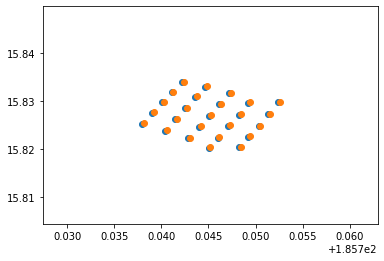

In [22]:
# can only handle limited set, due to jupyter limitations
# look at the first and last 25 (since it's a 5 x 5 array)
# this shows the drizzling
ras0 = ra.ravel()[:25]
decs0 = dec.ravel()[:25]
ras1 = ra.ravel()[-25:]
decs1 = dec.ravel()[-25:]
plt.scatter(ras0,decs0)
plt.scatter(ras1,decs1)

7.033355551561083e-05 5.461417728701148e-05


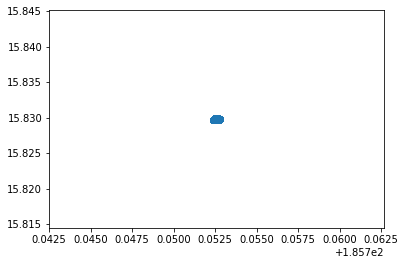

In [23]:
# look at the drizzling of a single of the 25
x=ra.ravel()
y=dec.ravel()
x=x[::25]
y=y[::25]
plt.scatter(x,y)
print(x.std(),y.std())

INFO: Auto-setting vmin to -3.848e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.936e-03 [aplpy.core]


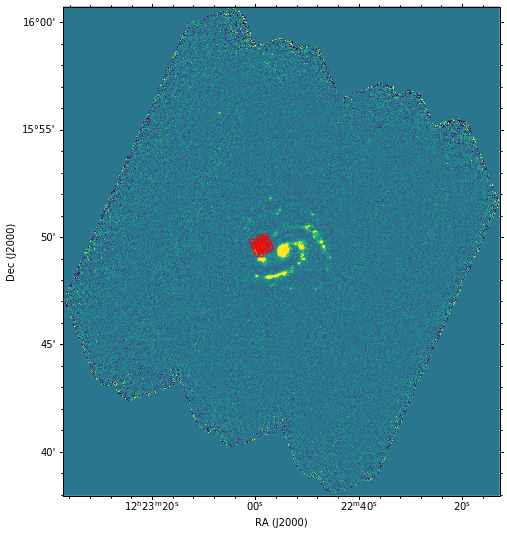

In [24]:
gc = aplpy.FITSFigure(hdu1)
gc.show_colorscale()
gc.show_markers(ras0,decs0)

# SpectralSimplecube

Only the EQ (equidistance) cubes can be easily plotted with AplPY

In [25]:
fr = pacs['HPS3DEQDR']
fb = pacs['HPS3DEQIB']
print(len(fr),len(fb))

(hdur0,h3,d3) = get_image(fr[0])
(hdur1,h3,d3) = get_image(fr[1])
(hdub0,h3,d3) = get_image(fb[0])
(hdub1,h3,d3) = get_image(fb[1])

2 2
get_image: 1342223728/level2/HPS3DEQDR/herschel.ia.dataset.spectrum.SpectralSimpleCube/hpacs1342223728_20hps3deqdrs_01_1469458813243.fits.gz
10 luns
(605, 35, 37)
Spectral axis: 156.9310679916835 160.2580129130602 um
get_image: 1342223728/level2/HPS3DEQDR/herschel.ia.dataset.spectrum.SpectralSimpleCube/hpacs1342223728_20hps3deqdrs_00_1469458812067.fits.gz
10 luns
(458, 32, 34)
Spectral axis: 176.39695143276194 178.8499239903976 um
get_image: 1342223728/level2/HPS3DEQIB/herschel.ia.dataset.spectrum.SpectralSimpleCube/hpacs1342223728_20hps3deqibs_01_1469458815654.fits.gz
9 luns
(974, 25, 25)
Spectral axis: 78.49095392473981 80.12953301205803 um
get_image: 1342223728/level2/HPS3DEQIB/herschel.ia.dataset.spectrum.SpectralSimpleCube/hpacs1342223728_20hps3deqibs_00_1469458815168.fits.gz
9 luns
(769, 25, 25)
Spectral axis: 88.22227127451995 89.44617616515035 um


In this case both the red and blue have two cubes:


INFO: Auto-setting vmin to -1.515e-01 [aplpy.core]
INFO: Auto-setting vmax to  4.351e-01 [aplpy.core]
INFO: Auto-setting vmin to -1.636e-01 [aplpy.core]
INFO: Auto-setting vmax to  3.130e-01 [aplpy.core]
INFO: Auto-setting vmin to -1.607e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.846e-01 [aplpy.core]
INFO: Auto-setting vmin to -1.591e+00 [aplpy.core]
INFO: Auto-setting vmax to  9.245e-01 [aplpy.core]


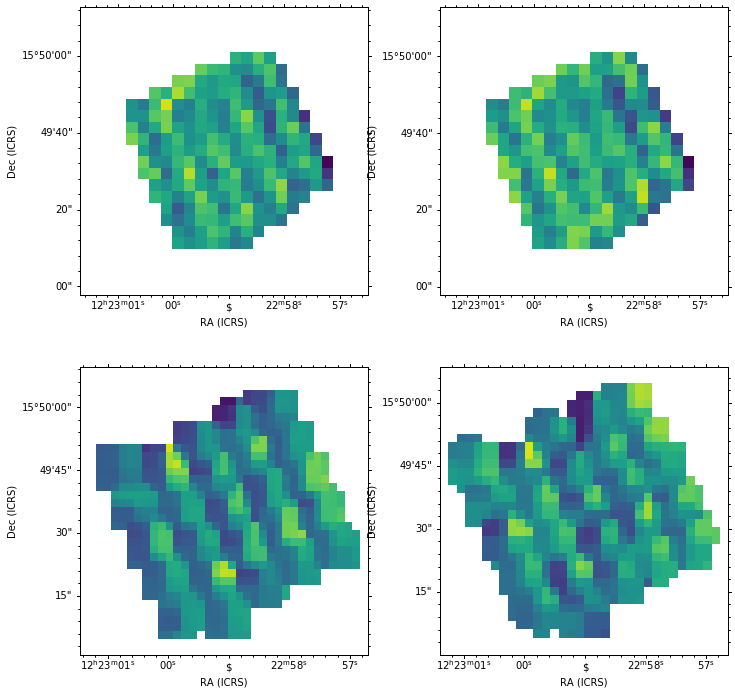

In [26]:
fig = plt.figure(figsize=(10,10))
g1 = aplpy.FITSFigure(hdur0,slices=[400],subplot=[0.1,0.1,0.4,0.4], figure=fig)
g1.show_colorscale()
g2 = aplpy.FITSFigure(hdur1,slices=[400],subplot=[0.6,0.1,0.4,0.4], figure=fig)
g2.show_colorscale()
g3 = aplpy.FITSFigure(hdub0,slices=[400],subplot=[0.1,0.6,0.4,0.4], figure=fig)
g3.show_colorscale()
g4 = aplpy.FITSFigure(hdub1,slices=[400],subplot=[0.6,0.6,0.4,0.4], figure=fig)
g4.show_colorscale()

#g2.hide_yaxis_label()
#g2.hide_ytick_labels()

# PacsSpecTable


In [27]:
tr = pacs['HPSTBRR']
tb = pacs['HPSTBRB']
print(len(tr),len(tb))

(rapr0,decpr0) = get_radec_pacs(tr[0])
(rapr1,decpr1) = get_radec_pacs(tr[1])
(rapb0,decpb0) = get_radec_pacs(tb[0])
(rapb1,decpb1) = get_radec_pacs(tb[1])


2 2
get_radec_pacs: 1342223728/level2/HPSTBRR/herschel.pacs.signal.PacsSpecTable/hpacs1342223728_20hpstbrrs_01_1469458817669.fits.gz
6 luns
Spectra 21200
Wavelength: 156.9611661266434 160.2821143023659
get_radec_pacs: 1342223728/level2/HPSTBRR/herschel.pacs.signal.PacsSpecTable/hpacs1342223728_20hpstbrrs_00_1469458817402.fits.gz
6 luns
Spectra 16000
Wavelength: 176.42646838984905 178.8721513702209
get_radec_pacs: 1342223728/level2/HPSTBRB/herschel.pacs.signal.PacsSpecTable/hpacs1342223728_20hpstbrbs_00_1469458816412.fits.gz
6 luns
Spectra 26800
Wavelength: 88.23106719570934 89.45255942349453
get_radec_pacs: 1342223728/level2/HPSTBRB/herschel.pacs.signal.PacsSpecTable/hpacs1342223728_20hpstbrbs_01_1469458816745.fits.gz
6 luns
Spectra 34000
Wavelength: 78.5002105041251 80.13596726629902


INFO: Auto-setting vmin to -3.998e-03 [aplpy.core]
INFO: Auto-setting vmax to  5.296e-03 [aplpy.core]


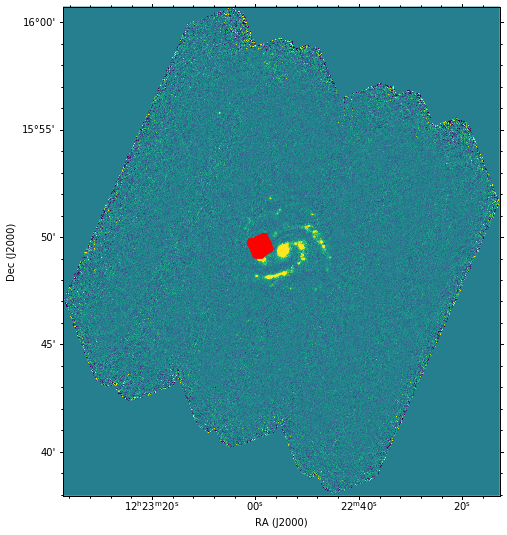

In [28]:
gc = aplpy.FITSFigure(hdu1)
gc.show_colorscale()
gc.show_markers(rapr0[::500],decpr0[::500])
gc.show_markers(rapr1[::500],decpr1[::500])
gc.show_markers(rapb0[::500],decpb0[::500])
gc.show_markers(rapb1[::500],decpb1[::500])




# SpirePacsParallel

For reference, here are the Blue and Red ones for this mode. It's photometry, so we will not be covering that here.

     1342198147/level2/HPPPMAPB/hpacs1342198147_20hpppmapb_00_1469312216448.fits.gz       6241 x 6521
     1342198147/level2/HPPPMAPR/hpacs1342198147_20hpppmapr_00_1469312277296.fits.gz       6242 x 6522


# AstroQuery


See also    https://astroquery.readthedocs.io/en/latest/irsa/irsa.html

    >>> from astroquery.irsa import Irsa
    >>> Irsa.print_catalogs()

    z0mgsdr1index                   z0MGS DR1 Index
    z0mgsdr1simple                  z0MGS DR1 7.5 arcsec Simple Index
    
    ppsc_70                         PACS Point Source Catalog: 70 microns
    ppsc_100                        PACS Point Source Catalog: 100 microns
    ppsc_160                        PACS Point Source Catalog: 160 microns
    ppsc_extsl                      PACS Point Source Catalog: Extended Source List
    ppsc_obstbl                     PACS Point Source Catalog: Observation Table
    ppsc_rejsl                      PACS Point Source Catalog: Rejected Source List
    spsc250                         SPIRE Point Source Catalog: 250 microns
    spsc350                         SPIRE Point Source Catalog: 350 microns
    spsc500                         SPIRE Point Source Catalog: 500 microns
    spscxid                         SPIRE Point Source Catalog Cross-Reference Matrix


In [29]:
from astroquery.irsa import Irsa
from astropy import coordinates
import astropy.units as u    

In [30]:
t70 = Irsa.query_region("ngc4321",catalog="ppsc_70", spatial="Cone",radius=4 * u.arcmin)    

In [31]:
print(t70)

           name            band     ra     ... ssomapflag    dist      angle   
                                   deg     ...              arcsec      deg    
-------------------------- ---- ---------- ... ---------- ---------- ----------
HPPSC070A_J122251.3+154933 blue 185.714066 ...          f  51.890385 286.105027
HPPSC070A_J122254.6+154819 blue 185.727568 ...          f  59.827221 182.959848
HPPSC070A_J122258.8+154937 blue 185.745090 ...          f   60.46935  72.271844
HPPSC070A_J122257.0+154809 blue 185.737772 ...          f  76.623529 155.103199
HPPSC070A_J122300.2+154921 blue 185.750992 ...          f  78.091491  87.973581
HPPSC070A_J122257.4+154809 blue 185.739407 ...          f  79.572565 151.540068
HPPSC070A_J122248.7+155000 blue 185.703166 ...          f  97.121465 295.578113
HPPSC070A_J122259.8+154812 blue 185.749443 ...          f  98.811773 132.644404
HPPSC070A_J122248.7+155014 blue 185.703088 ...          f 103.907117 302.255961
HPPSC070A_J122253.2+154736 blue 185.7219

In [32]:
t500 = Irsa.query_region("ngc4321",catalog="spsc500", spatial="Cone",radius=4 * u.arcmin)  

In [33]:
print(t500)

          spscid          det    ra    ...       q3ctile         dist    angle  
                                deg    ...                      arcsec    deg   
------------------------- --- -------- ... ------------------- ------- ---------
HSPSC500A_J1222.91+1549.3 PLW 185.7288 ... 4361459162178125823 1.55012 49.437796


# pySpecKit

It's possible that this package can help displaying and fitting spectra.  TBD.


# KingFish

The KingFish team as a separate download, in 3 tar files on http://archives.esac.esa.int/hsa/legacy/UPDP/KINGFISH-DR3/ and covers 61 galaxies

    SPIRE IMAG : maps at 250,350 and 500um  (18 fits files per object)
          NGC4321_kingfish_spire250_v3-0_hipe.fits
          NGC4321_kingfish_spire250_v3-0_scan.fits
          
    PACS SPEC : cube and m0 fits file for a selected number of lines 
          CII (158), NII122 (122), NII205 (205), OIII (88), OI (63)
          ngc4321_OI_cube.fits
             
    PACS IMAG : maps at 70, 100 and 160um  (3 fits files per object)
          NGC4321_scanamorphos_v16.9_pacs70_0.fits
    
    
    
The 3rd axis WCS in PACS SPEC is not clear to me. There is something useful in META_64

